#Boundary element method for potential flow

In this note book, we aim at demonstrating the use of boundary element method in calculating a potential flow problem in fluid mechanics. 

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
eps=1e-10

The potential flow is defined as a flow of inviscid incompressible fluid, where there exists a function $\phi (x,y,z)$, known as velocity potential that allows the calculation of the velocity components as follows:

$$
\begin{equation*}
\mathbf{u}=\nabla \phi
\tag{1}\end{equation*}
$$

The continuity equation for incompressible fluid:

$$
\begin{equation*}
\nabla \cdot \mathbf{u}=0
\tag{2}\end{equation*}
$$

From equations (1) and (2), it can be seen that the velocity potential obeys Laplace's equation:

$$
\begin{equation*}
\nabla ^2 \phi=0
\tag{3}\end{equation*}
$$

Hence, once the boundary values are determined, it is possible to solve for $\phi$ in the whole domain using Boundary Element Method that was discussed in lecture. These $\phi$ are subsequently used to calculate the velocity components of the flow using (2).

In this notebook we will use this method to compute the steady solution of a 2-dimensional flow in a tube of length $l_x$, with a big inlet $l_y$ having inflow  velocity $u_0$ and a small outlet $d$ (Fig 1). With this system, the boundary conditiond for $\phi$ is expressed as in Fig 2.

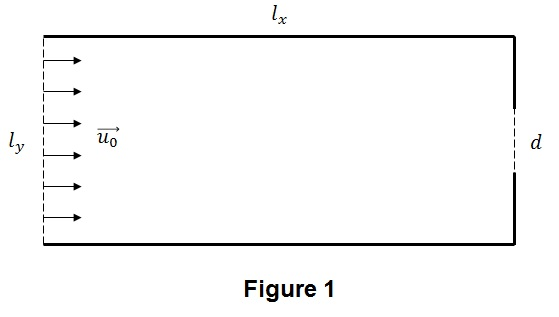

In [16]:
from IPython.display import Image
Image(filename=('D:\Dropbox\Study\Numerical methods for advanced fluids dynamics\Assignments\Assignment 3\Figure\Figure 1.JPG'))

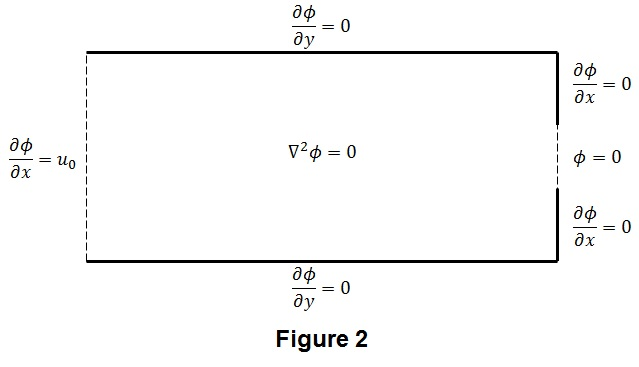

In [17]:
Image(filename=('D:\Dropbox\Study\Numerical methods for advanced fluids dynamics\Assignments\Assignment 3\Figure\Figure 2.JPG'))

In [2]:
def CalcF(xi,eta,xk,yk,nkx,nky,L):
    A=L**2.
    B=2.*L*(-nky*(xk-xi)+nkx*(yk-eta))
    E=(xk-xi)**2.+(yk-eta)**2.
    M=np.sqrt(np.fabs(4.*A*E-B**2.))
    BA=B/A
    EA=E/A
    if (M<eps):
        F1=0.5/np.pi*L*(np.log(L)+(1+0.5*BA)*np.log(np.fabs(1+0.5*BA))-\
                          1-0.5*BA*np.log(np.fabs(0.5*BA)))
        F2=0.
    else:
        F1=1./np.pi*0.25*L*(2.*(np.log(L)-1.)-0.5*BA*np.log(np.fabs(EA))+\
                   (1.+0.5*BA)*np.log(np.fabs(1.+BA+EA))+\
                   (M/A)*(np.arctan((2.*A+B)/M)-np.arctan(B/M)))
        F2=1./np.pi*L*(nkx*(xk-xi)+nky*(yk-eta))/M*(np.arctan((2.*A+B)/M)-np.arctan(B/M))
        
    return F1,F2

In [3]:
def CELAP1(N,xm,ym,xb,yb,nx,ny,lg,BCT,BCV):
    B=np.zeros(N)
    A=np.zeros((N,N))
    phi=np.zeros(N)
    dphi=np.zeros(N)
    for m in range(N):
        for k in range(N):
            F1,F2=CalcF(xm[m],ym[m],xb[k],yb[k],nx[k],ny[k],lg[k])
            if (k==m):
                delta=1.
            else:
                delta=0.
            if (BCT[k]==0):
                A[m,k]=-F1
                B[m]=B[m]+BCV[k]*(-F2+.5*delta)
            else:
                A[m,k]=F2-0.5*delta
                B[m]=B[m]+BCV[k]*F1
                
    Z=np.linalg.solve(A,B)
    
    for m in range(N):
        if (BCT[m]==0):
            phi[m]=BCV[m]
            dphi[m]=Z[m]
        else:
            phi[m]=Z[m]
            dphi[m]=BCV[m]
    
    return phi, dphi       

In [4]:
def CELAP2(N,xi,eta,xb,yb,nx,ny,lg,phi,dphi):
    mysum=0.
    for i in range(N):
        F1,F2=CalcF(xi,eta,xb[i],yb[i],nx[i],ny[i],lg[i])
        mysum=mysum+phi[i]*F2-dphi[i]*F1
    return mysum

In [12]:
#======THE MAIN PROGRAM=======#

#-----Input parameter-----#

#Inlet velocity:
u0=2.0
#Wall length
lx=2.0
ly=1.0
#Output width
d=0.4
#Number of elements per side
N0=50
#Total number of elements
N=4*N0
#Gridlength
dx=lx/N0; dy=ly/N0

#-----Calculate boundary values of phi-----#

#Position of the corners
xb=np.zeros(N+1)
yb=np.zeros(N+1)
#Position of the midpoint
xm=np.zeros(N)
ym=np.zeros(N)
#Element length
lg=np.zeros(N)
#Normal vector
nx=np.zeros(N)
ny=np.zeros(N)
#Type of boundary condition
BCT=np.zeros(N)
#Values of boundary condition
BCV=np.zeros(N)

#Position of the boundaries:
for i in range (N0):
    xb[i]=i*dx                 #bottom
    yb[i]=0.
    
    xb[N0+i]=lx              #right
    yb[N0+i]=i*dy
    
    xb[2*N0+i]=lx-i*dx       #top
    yb[2*N0+i]=ly
    
    xb[3*N0+i]=0.                #left
    yb[3*N0+i]=ly-i*dy

xb[N]=xb[0]
yb[N]=yb[0]

#Position of midpoints + length of elements + normal vectors
for i in range (N):
    xm[i]=0.5*(xb[i]+xb[i+1])      # midpoints
    ym[i]=0.5*(yb[i]+yb[i+1])
    
    lg[i]=np.sqrt((xb[i+1]-xb[i])**2.+(yb[i+1]-yb[i])**2.)     #length
    
    nx[i]=(yb[i+1]-yb[i])/lg[i]      #normal vector
    ny[i]=(-xb[i+1]+xb[i])/lg[i]
    
#Setup boundary conditions
for i in range (N):
    if (i<N0):           #bottom
        BCT[i]=1
        BCV[i]=0.
        
    elif (i<=N0+(ly-d)/2/dy):       #right-lower wall
        BCT[i]=1
        BCV[i]=0.
        
    elif (i<N0+(ly+d)/2/dy):      #right-out let
        BCT[i]=0
        BCV[i]=0.
    
    elif (i<2*N0):       #right-upper wall
        BCT[i]=1
        BCV[i]=0.
        
    elif (i<3*N0):       #top
        BCT[i]=1
        BCV[i]=0
        
    else:                #left
        BCT[i]=1
        BCV[i]=u0

#Calculate all boundary values
phi,dphi=CELAP1(N,xm,ym,xb,yb,nx,ny,lg,BCT,BCV)

#------Calculate velocity potential for the domain-------#

#Generate the grid:
Nx=2*N0; Ny=N0
dx=lx/(Nx); dy=ly/(Ny)
x=np.linspace(0.,lx,Nx+1); y=np.linspace(0.,ly,Ny+1)
X,Y=np.meshgrid(x,y)
phi_bem=np.zeros((Ny+1,Nx+1))

#Calculate potential for the whole domain:
for i in range (1,Ny):
    for j in range (1,Nx):
        phi_bem[i,j]=CELAP2(N,X[i,j],Y[i,j],xb,yb,nx,ny,lg,phi,dphi)

#Calculate the potential for the boundary:
for i in range (0,Nx):        #top and bottom
    phi_bem[0,i]=phi_bem[1,i]
    phi_bem[Ny,i]=phi_bem[Ny-1,i]
    
for i in range (0,Ny):        #left and right
    phi_bem[i,0]=phi_bem[i,1]-u0*dx
    if (i<=(ly-d)/2./dy):
        phi_bem[i,Nx]= phi_bem[i,Nx-1]
    elif (i<(ly+d)/2./dy):
        phi_bem[i,Nx]=0
    else:
        phi_bem[i,Nx]=phi_bem[i,Nx-1]
        

#------Calculate the velocity-------#
    
#Initialize the grid
u=np.zeros((Ny+1,Nx+1))
v=np.zeros((Ny+1,Nx+1))

#Calculate the velocity inside the whole domain
u[1:-1,1:-1]=0.5/dx*(phi_bem[1:-1,0:-2]-phi_bem[1:-1,2:])
v[1:-1,1:-1]=0.5/dy*(phi_bem[0:-2,1:-1]-phi_bem[2:,1:-1])

#Apply boundary condition for velocity
u[0,:]=0; v[0,:]=0          #top wall
u[Ny,:]=0; v[Ny,:]=0         #bottom wall
u[:,0]=u0; v[:,0]=0         #inlet

for i in range (0,Ny):        #outlet
    if (i<=(ly-d)/2./dy):
        u[i,Nx]=0; v[i,Nx]=0
    elif (i<(ly+d)/2./dy):
        u[i,Nx]=u[i,Nx-1]; v[i,Nx]=v[i,Nx-1]
    else:
        u[i,Nx]=0; v[i,Nx]=0

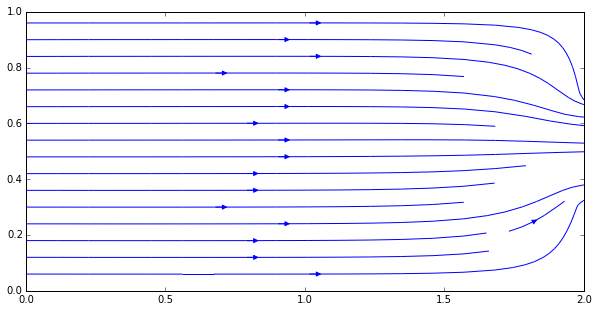

In [15]:
#plot the graph
fig=plt.figure(figsize=(10,5), dpi=300)
plt.streamplot(X,Y,u,v, density=0.6)